# Movie recommender with multinomial RBM (Python, Tensorflow, GPU)

A Restricted Boltzmann Machine (RBM) is used to perform collaborative filtering over the Movielens dataset.
The RBM is a generative model, it learns the joint probability distribution $P(v,h)$, where $v$ are the visible units and $h$ the hidden ones. The hidden units are latent variables while the visible units are clamped on the input data. The model generates ratings for a user/movie pair using a collaborative filtering based approach. 

The dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users. The movies are ranked from 1-5; In the first iteration of this notebook we consider a simplifie version of the problem, implementing a binary encoding of the dataset. The reason for this choice is that one can use a more traditional binary RBM instead of a multinomial one, see below for further discussion.



## 0 Global Settings and Import

In [1]:
#load libraries

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm
from zipfile import ZipFile

from reco_utils.recommender.rbm.Mrbm_tensorflow import RBM
from reco_utils.dataset.python_splitters import python_stratified_split, python_random_split
from reco_utils.dataset.url_utils import maybe_download
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4


# 1 Load Data 

In [2]:
# Select Movielens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

In [3]:
# MovieLens data have different data-format for each size of dataset 
data_header = None
if MOVIELENS_DATA_SIZE == '100k':
    separator = '\t'
    data_name = 'u.data'
    data_folder = 'ml-100k'
elif MOVIELENS_DATA_SIZE == '1m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-1m'
elif MOVIELENS_DATA_SIZE == '10m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-10M100K'
elif MOVIELENS_DATA_SIZE == '20m':
    separator = ','
    data_name = 'ratings.csv'
    data_folder = 'ml-20m'
    data_header = 0
else:
    raise ValueError('Invalid data size. Should be one of {100k, 1m, 10m, or 20m}') 

# Download dataset zip file and decompress if haven't done yet
data_path = os.path.join(data_folder, data_name)
if not os.path.exists(data_path):
    filename = 'ml-' + MOVIELENS_DATA_SIZE + '.zip'
    filepath = maybe_download('http://files.grouplens.org/datasets/movielens/'+filename, filename)

    with ZipFile(filepath, 'r') as zf:
        zf.extractall()
    
    # remove zip file we already used
    os.remove(filepath)
    
data = pd.read_csv(
    data_path,
    sep=separator,
    engine='python',
    names=['userID','MovieId','Rating','Timestamp'],
    header=data_header
)
data.head()

,userID,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 1.2 Split the data using the stratified python splitter  

In [4]:
train, test = python_stratified_split(data)

## 2 Train the RBM model






In [5]:
header = {
        "col_user": "userID",
        "col_item": "MovieId",
        "col_rating": "Rating",
    }


model = RBM(hidden_units= 500, keep_prob= .7, training_epoch = 10, minibatch_size= 120, momentum = .9,**header)

Generating the user/item affinity matrix...
Creating the computational graph


Matrix generated, sparsness 96 %
martrix size 6040 3659
training epoch 0 rmse Train 0.933394 
training epoch 10 rmse Train 0.906775 
Total precision on the train set 0.3193774


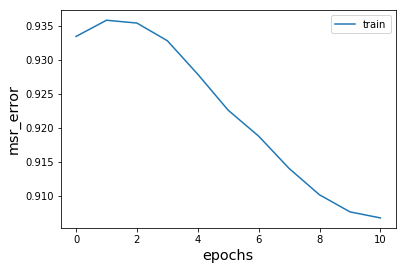

In [6]:
var = model.fit(train)

In [14]:
var[2].shape

(1, 500)

In [79]:
TOP_K = 10

top_k = model.recommend_k_items(test, top_k = TOP_K)

# TODO: remove this call when the model returns same type as input
top_k['userID'] = pd.to_numeric(top_k['userID'])
top_k['MovieId'] = pd.to_numeric(top_k['MovieId'])

display(top_k.head() ) 

Restoring parameters from saver/rbm_model_saver.ckpt
Formatting output


,userID,MovieId,prediction
0,1,2761,4.998879
1,1,526,4.998627
2,1,2265,4.998390
3,1,2790,4.998356
4,1,1960,4.997555


## 4 Evaluation metrics 

Here we evaluate the performance of the algorithm using the metrics provided in the `PythonRankingEvaluation` class

In [80]:
eval_map = map_at_k(test, top_k, col_user="userID", col_item="MovieId", 
                    col_rating="Rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= TOP_K)

In [81]:
eval_ndcg = ndcg_at_k(test, top_k, col_user="userID", col_item="MovieId", 
                      col_rating="Rating", col_prediction="prediction", 
                      relevancy_method="top_k", k=TOP_K)

In [82]:
eval_precision = precision_at_k(test, top_k, col_user="userID", col_item="MovieId", 
                                col_rating="Rating", col_prediction="prediction", 
                                relevancy_method="top_k", k= TOP_K)

In [83]:
eval_recall = recall_at_k(test, top_k, col_user="userID", col_item="MovieId", 
                          col_rating="Rating", col_prediction="prediction", 
                          relevancy_method="top_k", k=TOP_K)

In [84]:
print(
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Top K:	10
MAP:	0.001734
NDCG:	0.020380
Precision@K:	0.020000
Recall@K:	0.005386
